ИССЛЕДОВАНИЕ ДАННЫХ О ПОЛЬЗОВАТЕЛЯХ СЕРВИСА АРЕНДЫ САМОКАТОВ GoFast

Данный проект посвящен исследованию данных о пользователях популярного сервиса аренды самокатов GoFast. В нашем распоряжении данные о пользователях из нескольких городов, а также об их поездках и подписках.

Цель проекта - проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться без подписки (т.е. без абонентской платы - цена одной минуты поездки составляет 8 рублей и стоимость старта 50 рублей) или с подпиской Ultra (абонентская плата 199 рублей) - цена составляет 6 руб./минута, за старт деньги не взимаются.

1й датафрейм содержит данные о пользователях, второй - о поездках, 3й - о подписках.

В данном проекте данные будут проверены, предобработаны, объединены и проанализированы. Также будут выдвинуты и рассмотрены некоторые гипотезы касательно выручки, расстояния, технической поддержки сервиса.

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt
import seaborn as sns

#### Шаг 1. Загрузка данных

In [ ]:
users=pd.read_csv('/datasets/users_go.csv')
rides=pd.read_csv('/datasets/rides_go.csv')
subs=pd.read_csv('/datasets/subscriptions_go.csv')

#### Шаг 2. Предобработка данных

1.2 Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

In [ ]:
print (users.sample(10))

      user_id      name  age            city subscription_type
1148     1149     Самир   25    Екатеринбург              free
40         41    Данила   21    Екатеринбург             ultra
213       214      Иван   20       Краснодар             ultra
300       301  Вячеслав   24  Ростов-на-Дону             ultra
1506     1507  Вячеслав   26    Екатеринбург              free
789       790     Марат   23            Сочи              free
1437     1438    Тамара   30       Пятигорск              free
983       984  Анжелика   34       Краснодар              free
1491     1492  Григорий   36       Краснодар              free
785       786  Виолетта   23            Сочи              free


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [ ]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [ ]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [ ]:
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [ ]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


   
<b> ПРОМЕЖУТОЧНЫЙ ВЫВОД <b>

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
В первом датафрейме содержится 1565 строки с информацией о пользователях. Данные об ID пользователя и возраста - целочисленные, остальное - строчные (object), что никак не мешает обработке.
Во втором датафрейме содержится 18068 строк с информацией о поездках данных пользователей. Данные об ID пользователя также целочисленные, информация о продолжительности и расстоянии поездки - float (не противоречит), данные о дате нуждаются в переводе в формат даты.
Третий датафрейм - "сервисный", в нем всего 2 строки с указанием условий подписки (формат даты тоже нареканий не вызывает).

2.1 Приводим столбец date к типу даты pandas.

In [ ]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

2.2 Создаем новый столбец с номером месяца на основе столбца date.

Проверяем за какой период данные - чтобы не было дублирования месяцев за разные года

In [ ]:
print ('Данные за период с ', rides['date'].min(), 'по ', rides['date'].max())

Данные за период с  2021-01-01 00:00:00 по  2021-12-30 00:00:00


In [ ]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

2.3 Проверяем наличие пропущенных значений и дубликатов в датафреймах и обрабатываем их, если такие значения присутствуют.

In [ ]:
print (users.isna().sum())
print('Число дубликатов:', users.duplicated().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
Число дубликатов: 31


In [ ]:
users=users.drop_duplicates()

In [ ]:
print (rides.isna().sum())
print('Число дубликатов:', rides.duplicated().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
Число дубликатов: 0


#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:

3.1 частота встречаемости городов

In [ ]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

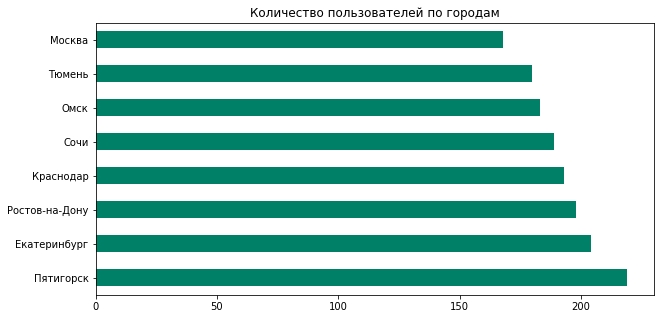

In [ ]:
users['city'].value_counts().plot (kind = 'barh', figsize=(10,5), \
                                   cmap='summer',\
                                   use_index=True,
                                   title = 'Количество пользователей по городам');

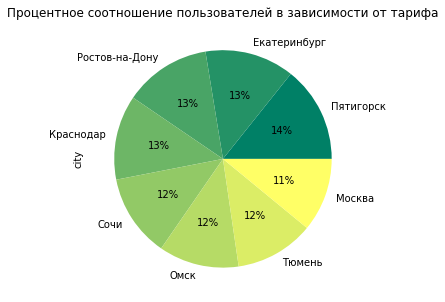

In [ ]:
users['city'].value_counts().plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    figsize=(5,5),
    cmap='summer',
    title = 'Процентное соотношение пользователей в зависимости от тарифа');

3.2 соотношение пользователей с подпиской и без подписки

In [ ]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

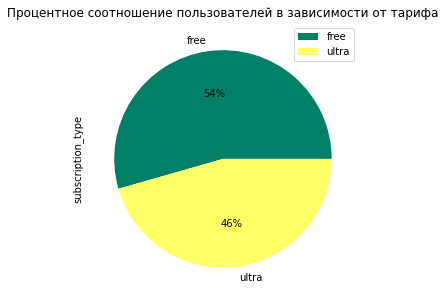

In [ ]:
users['subscription_type'].value_counts().plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    figsize=(5,5),
    legend=True,
    cmap='summer',
    title = 'Процентное соотношение пользователей в зависимости от тарифа');

   
Изучив базу данных пользователей, мы выяснили, что пользователей без подписки (free) - 835, а пользователей с подпиской ultra - 699, что в процентном соотношении выражается как 54% против 46%.

3.3 возраст пользователей

In [ ]:
users['age'].value_counts()
print ('Минимальный возраст пользователя: ', users['age'].min())
print ('Максимальный возраст пользователя: ', users['age'].max())

Минимальный возраст пользователя:  12
Максимальный возраст пользователя:  43


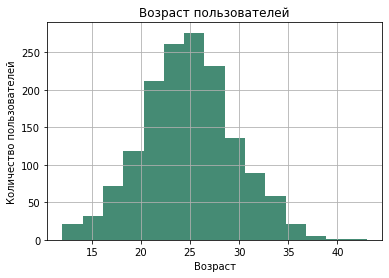

In [ ]:
plt.hist(users['age'], bins = 15, color='#458B74')
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()



In [ ]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

3.4 расстояние, которое пользователь преодолел за одну поездку

In [ ]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

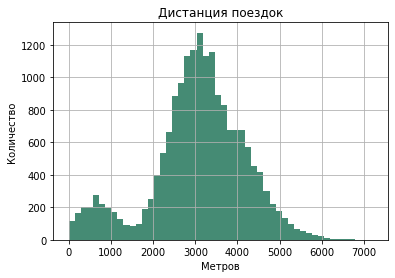

In [ ]:
plt.hist(rides['distance'], bins = 50, color='#458B74')
plt.title('Дистанция поездок')
plt.xlabel('Метров')
plt.ylabel('Количество')
plt.grid()
plt.show()

(600.0, 6000.0)

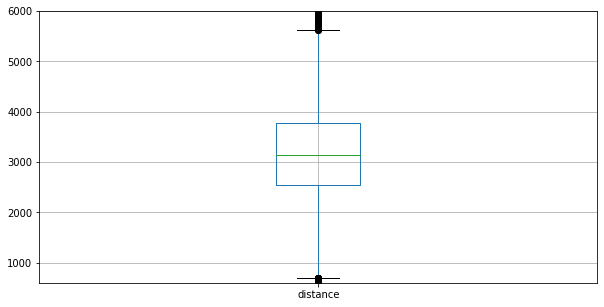

In [ ]:
rides[['distance']].boxplot(figsize=(10,5))
plt.ylim(600, 6000)

Средняя длина поезди составляет 3071 м., медиана - 3134 м, основная масса поездок в промежутке между 2543 м 3776 м, минимальная дистанция - 0,85м, максимальная - 7211 м. Также наблюдается всплеск на 700 м., можно предположить, что это обусловлено перемещениями между точками аренды в пределах центральной локации всех точек аренды. Выбросы есть как снизу (меньше 680), так и сверху  (5600)..

3.5. продолжительность поездок

In [ ]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

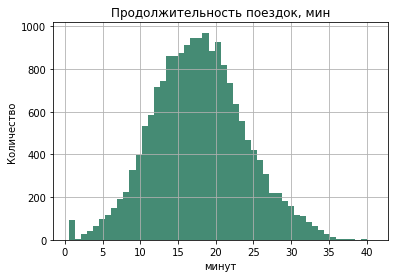

In [ ]:
plt.hist(rides['duration'], bins = 50, color='#458B74')
plt.title('Продолжительность поездок, мин')
plt.xlabel('минут')
plt.ylabel('Количество')
plt.grid()
plt.show()

(0.0, 40.0)

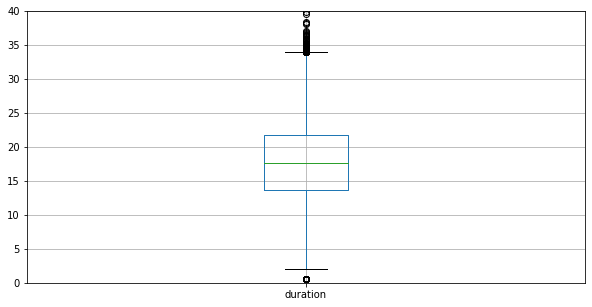

In [ ]:
rides[['duration']].boxplot(figsize=(10,5))
plt.ylim(0, 40)

   
Средняя продолжительность поездки составляет 17,8 минут, медиана - 17,7 мин, основная масса поездок в промежутке между 13,6 и 21,7 минут, минимальная продолжительность - 0,5 мин, максимальная - 40 мин. Также наблюдается всплеск на 1 минуте, можно предположить, это какие-то пробные, ошибочные или "не разобрался". Выбросы есть как снизу (меньше 2 минут), так и сверху (свыше 34 минут)

In [ ]:
total_distance_by_user = rides.groupby(['user_id']).sum()
total_distance_by_user.head()

,distance,duration,month
user_id,,,
1,34070.182066,204.604909,99
2,33964.058614,197.644279,67
3,36907.597866,233.193513,66
4,44837.189916,288.563581,107
5,35556.949649,174.073932,51


#### Шаг 4. Объединение данных

4.1 Объединяем данные о пользователях, поездках и подписках в один датафрейм методом merge().

In [ ]:
two_df = rides.merge(users, on='user_id', how='left')
data = two_df.merge (subs, on='subscription_type', how='left')
data.sample(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
7043,737,6386.938020,25.967345,2021-07-31,7,Мелания,27,Ростов-на-Дону,free,8,50,0
14713,1295,2838.988951,19.308864,2021-07-08,7,Алиса,27,Сочи,free,8,50,0
9117,895,3401.154358,17.576376,2021-06-19,6,Мирон,25,Сочи,free,8,50,0
3753,403,3445.142476,14.395843,2021-10-06,10,Полина,19,Сочи,ultra,6,0,199
7283,755,2094.984245,19.669158,2021-01-01,1,Иван,21,Краснодар,free,8,50,0
8856,876,2840.132048,22.467107,2021-06-23,6,Никита,18,Екатеринбург,free,8,50,0
15222,1331,3733.104969,17.199315,2021-10-28,10,Савелий,19,Краснодар,free,8,50,0
16169,1401,2648.506102,16.945518,2021-05-11,5,Амина,21,Омск,free,8,50,0
11726,1082,2941.032449,27.705162,2021-05-22,5,Макар,24,Екатеринбург,free,8,50,0
11763,1085,3797.797917,23.114715,2021-01-12,1,Глеб,24,Пятигорск,free,8,50,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


4.2 Создаем ещё два датафрейма из датафрейма, созданного на этапе 4.1:

c данными о пользователях без подписки;

с данными о пользователях с подпиской.

In [ ]:
free_users = data.query("subscription_type == 'free'")
ultra_users = data.query("subscription_type == 'ultra'")
free_users.sample(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
15032,1318,2787.678472,17.194841,2021-05-18,5,Мадина,28,Москва,free,8,50,0
7287,755,4432.003258,21.642364,2021-06-15,6,Иван,21,Краснодар,free,8,50,0
11388,1057,2334.379206,17.238985,2021-05-19,5,Адель,26,Москва,free,8,50,0
11812,1088,3139.295520,12.727062,2021-02-01,2,Самир,28,Тюмень,free,8,50,0
9813,945,4879.620234,18.095766,2021-11-13,11,Александра,31,Сочи,free,8,50,0


In [ ]:
ultra_users.sample(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
2434,259,3729.146085,20.776251,2021-08-06,8,Карина,27,Краснодар,ultra,6,0,199
3869,416,3706.619906,20.885514,2021-08-20,8,Милена,31,Ростов-на-Дону,ultra,6,0,199
5758,614,4208.373208,27.041866,2021-10-10,10,Кристина,26,Ростов-на-Дону,ultra,6,0,199
409,44,3082.979593,19.561173,2021-02-21,2,Ясмина,25,Ростов-на-Дону,ultra,6,0,199
3602,387,1234.763317,11.630362,2021-04-27,4,Татьяна,22,Сочи,ultra,6,0,199


In [ ]:
ultra_users.info()
free_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB
<class 'pandas.core.frame.DataFrame'>
In

In [ ]:
11568+6500

18068

4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [ ]:
free_users_grouped = free_users.groupby(['user_id']).sum()
free_users_grouped.head()

,distance,duration,month,age,minute_price,start_ride_price,subscription_fee
user_id,,,,,,,
700,52202.109773,273.224942,105,396,144,900,0
701,62153.018852,289.779073,135,620,160,1000,0
702,41682.095810,232.031447,78,260,104,650,0
703,17382.000502,108.253356,50,210,56,350,0
704,50387.129242,266.533655,116,464,128,800,0


In [ ]:
ultra_users_grouped = ultra_users.groupby(['user_id']).sum()
ultra_users_grouped.sample(5)
ultra_users_grouped.describe()

,distance,duration,month,age,minute_price,start_ride_price,subscription_fee
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.0,699.000000
mean,28970.522206,172.421894,59.721030,231.476395,55.793991,0.0,1850.500715
std,10370.610254,61.061422,23.894065,91.748585,19.155611,0.0,635.327773
min,5530.344048,34.157765,9.000000,40.000000,12.000000,0.0,398.000000
25%,21411.243798,126.094588,42.000000,163.500000,42.000000,0.0,1393.000000
50%,28630.341916,169.739505,59.000000,222.000000,54.000000,0.0,1791.000000
75%,35708.654860,209.445901,75.000000,288.000000,66.000000,0.0,2189.000000
max,65393.983354,411.822515,159.000000,630.000000,126.000000,0.0,4179.000000


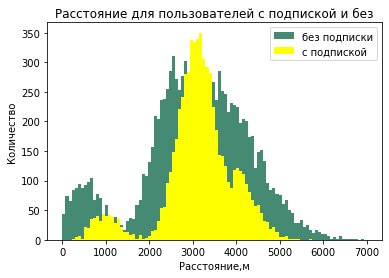

In [ ]:
plt.hist (free_users['distance'],bins=100, range=(0, 7000), color='#458B74')
plt.hist (ultra_users['distance'],bins=100, range=(0, 7000), color='#FFFF00')
plt.figure.figsize=(30, 20)
plt.title ('Расстояние для пользователей с подпиской и без')
plt.xlabel ('Расстояние,м')
plt.ylabel ('Количество')
plt.legend (('без подписки', 'с подпиской'))
plt.show()

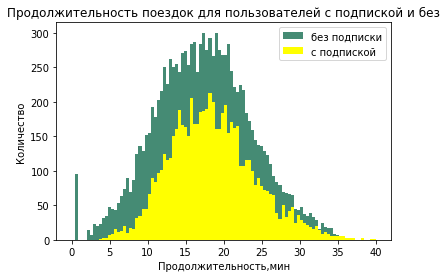

In [ ]:
plt.hist (free_users['duration'],bins=100, range=(0, 40), color='#458B74')
plt.hist (ultra_users['duration'],bins=100, range=(0, 40), color='#FFFF00')
plt.title ('Продолжительность поездок для пользователей с подпиской и без')
plt.xlabel ('Продолжительность,мин')
plt.ylabel ('Количество')
plt.legend (('без подписки', 'с подпиской'))
plt.figure.figsize=(30, 20)
plt.show()

In [ ]:
free_users['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [ ]:
ultra_users['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Пользователи без подписки совершили 11568 поездок, средняя дистанция - 3045 м, медиана - 3148 м,  минимальная - 0,85м, максимальная - 7211 м. В промежуток между 1м и 3м квартилем попадает расстояние от 2366 до 3905 м. Пользователи без подписки совершили 6500 поездок на среднюю дистанцию 3115 м., медиана - 3114 м, минимальная была на 244 м., максимальная на 5699 м., в промежуток между 1м и 3м квартилем попадает расстояние от  2785 до 3560 м. В среднем пользователь без подписки совершает 13,85 поездок, а пользователь с подпиской - 9,3 поездки.  
    
На гистограмме видно, что пользователи без подписки совершают большое количество коротких поездок, "всплеск" слева у пользователей без подписки смещен к 500 м., а с подпиской - к 1000 м (что по всем поездкам в п.3.4. дает 700 м). В целом графики расстояний и длительности схожи, за исключением всплеска (около 100) коротких поездок без подписки. Тут возможны варианты: передумали, не разобрались, не понравилось.  
    
Таким образом, можно зафиксировать, что пользователи без подписки совершили почти вдвое больше поездок, средняя дистанция поездок без подписки незначительно меньше поездок по подписке, а вот разброс минимальных и максимальных значений без подписки гораздо шире, также шире диапазон 1-3й квартилей.


#### Шаг 5. Подсчёт выручки

5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляем до следующего целого числа: например, значения 25.3, 25.5, 26.0 должны быть преобразованы к 26.

In [ ]:
# Округление продолжительности поездок в 'duration'
data['duration'] = np.ceil(data['duration'])
# Создание сводной таблицы
users_months_rides = data.pivot_table(
    index=('user_id', 'month'),
    values=(
        'distance',
        'duration',
        'minute_price',
        'start_ride_price',
        'subscription_fee'
    ),
    aggfunc=('count', 'sum'))
# Приводим названия в нормальный вид
users_months_rides.columns = [
    'count', 'distance',
    'count2', 'duration',
    'count3', 'minute_price',
    'count4', 'start_ride_price',
    'count5', 'subscription_fee'
]
users_months_rides = users_months_rides.drop(['count2', 'count3', 'count4', 'count5'], axis=1)

users_months_rides['start_ride_price'] = users_months_rides['start_ride_price'] / users_months_rides['count']
users_months_rides['minute_price'] = users_months_rides['minute_price'] / users_months_rides['count']

users_months_rides['subscription_fee'] = users_months_rides['subscription_fee'] / users_months_rides['count']

users_months_rides

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294      42.0           6.0               0.0   
        4          1    754.159807       7.0           6.0               0.0   
        8          2   6723.470560      46.0           6.0               0.0   
        10         2   5809.911100      32.0           6.0               0.0   
        11         3   7003.499363      56.0           6.0               0.0   
...              ...           ...       ...           ...               ...   
1534    6          2   3409.468534      26.0           8.0              50.0   
        8          2   7622.453034      48.0           8.0              50.0   
        9          1   4928.173852      23.0           8.0              50.0   
        11         4  13350.015305      78.0           8.0              50.0   
        12         1   2371.711192      16.0           8.0              50.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0  
...                         ...  
1534    6                   0.0  
        8                   0.0  
        9                   0.0  
        11                  0.0  
        12                  0.0  

[11331 rows x 6 columns]

5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обращаемся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки.

In [ ]:
users_months_rides['revenue'] = (
    (users_months_rides['start_ride_price'] * users_months_rides['count'])
    + (users_months_rides['minute_price'] * users_months_rides['duration'])
    + users_months_rides['subscription_fee']
)
users_months_rides['revenue'] = users_months_rides['revenue'].astype('uint16')
# Удаление столбцов со вспомогательными данными
#users_months_rides = users_months_rides.drop(['start_ride_price', 'minute_price'], axis=1)

users_months_rides.head(10)

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294      42.0           6.0               0.0   
        4          1    754.159807       7.0           6.0               0.0   
        8          2   6723.470560      46.0           6.0               0.0   
        10         2   5809.911100      32.0           6.0               0.0   
        11         3   7003.499363      56.0           6.0               0.0   
        12         2   6751.629942      28.0           6.0               0.0   
2       3          3  10187.723006      63.0           6.0               0.0   
        4          2   6164.381824      40.0           6.0               0.0   
        6          1   3255.338202      14.0           6.0               0.0   
        7          2   6780.722964      48.0           6.0               0.0   

               subscription_fee  revenue  
user_id month                             
1       1                 199.0      451  
        4                 199.0      241  
        8                 199.0      475  
        10                199.0      391  
        11                199.0      535  
        12                199.0      367  
2       3                 199.0      577  
        4                 199.0      439  
        6                 199.0      283  
        7                 199.0      487

Помесячная выручка считается по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки
× общая продолжительность всех поездок в минутах + стоимость подписки.

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H_0: Среднее время поездок пользователей с подпиской ultra равно времени  пользователей без подписки

H_1: Среднее время поездок пользователей с подпиской ultra больше времени  пользователей без подписки

In [ ]:
# H_0: ultra_users_duration > free_users_duration
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(
    ultra_users['duration'],
    free_users['duration'],
    alternative='greater',
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: среднее значение времени поездок пользователей с подпиской больше, чем пользователей без подписки.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, средние значения времени поездок из двух групп одинаковы')

p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу: среднее значение времени поездок пользователей с подпиской больше, чем пользователей без подписки.


In [ ]:
import statistics
data = free_users['duration']
statistics.variance(data)

40.02843442407168

  
У метода scipy.stats.ttest_ind есть аргумент equal_var (необязательный параметр). Он управляет тем, будет ли метод считать равными дисперсии выборок. Передаётся как equal_var=True или equal_var=False (True — считать, False — не считать). По умолчанию — True. На основании графика в п.4.3. можно предположить, что дисперсии не равны, поэтому мы меняем этот парамент на False

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

H_0: Среднее расстояние (distance), которое проезжают пользователи с подпиской ultra равно 3130 метров

H_1: Среднее расстояние (distance), которое проезжают пользователи с подпиской ultra больше 3130 метров

In [ ]:
target_dist = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    ultra_users['distance'],
    target_dist,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу, пользователи с подпиской проезжают больше 3130 м.')
else:
    print('Не отвергаем нулевую гипотезу, пользователи с подпиской проезжают не более 3130 м.')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу, пользователи с подпиской проезжают не более 3130 м.


ВЫВОД: износ самокатов не выходит ли за пределы оптимальности, на платной подписке средняя длина поездки примерно равна 3130 м в пределах статистической значимости (а в исследовательской части мы выяснили, что средняя длина = 3115 м), т.о. нулевая теория не отвергается, т.к. не выходит за пределы статистической значимости.


6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H_0: Выручка от пользователей c подпиской ultra равна выручке от пользователей без подписки

H_1: Выручка от пользователей с подпиской ultra больше выручки от пользователей без подписки

In [ ]:
alpha = 0.05
free_rev = users_months_rides.loc[users_months_rides.subscription_fee == 0, 'revenue']

ultra_rev = users_months_rides.loc[users_months_rides.subscription_fee > 0, 'revenue']


results = st.ttest_ind(ultra_rev,
                       free_rev,
                       alternative = 'greater')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, т.е. выручка от пользователей с подпиской ultra больше выручки от пользователей без подписки')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу, т.е. выручка от пользователей с подпиской ultra больше выручки от пользователей без подписки


ВЫВОД: Гипотеза о том, что платные и бесплатные пользователи приносят одинаковый доход была отвергнута, проверка показала, что выручка от пользователей c подпиской ultra больше выручки от пользователей без подписки.

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<div class="alert alert-info"> <b>В данном случае используется гипотеза о равенстве средних для зависимых (парных) выборок </b>

Гипотезы в таком случае будут сформулированы так:
    
H0 :μ1 = μ2
    
H1 :μ1 ≠ μ2
    
где μ1 и μ2  — средние значения до и после изменения

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применяется метод <b>scipy.stats.ttest_rel()<b> </div>

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

вероятность не выполнить план: 0.04976090094990328 при количестве попыток, равном = 1161


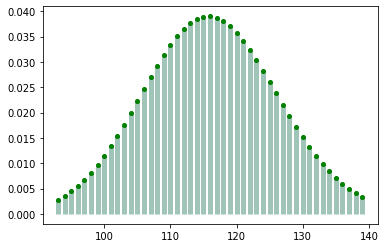

In [ ]:
from scipy.stats import binom
p=0.1 # вероятность успеха 10%

# вероятность неуспеха - то есть когда < 100 промокодов из n активировали
def probability_of_fail(n, p):
    distr=[]
    for k in range(0, 99 + 1):
        prob = binom.pmf (k,n,p)
        distr.append(prob)
    # F(99) = p(x=0) + p(x=1) ... + p(x=99)
    # p(x=C) = distr[C]
    # F(99) = distr[0] + distr[1] + ... + distr[99]
    F99 = 0
    for i in range(0, 99 + 1):
        F99 += distr[i]
    return F99 # P(x <= 99) - вероятность того, что число успехов <= 99

for n in range(1000, 1500):
    fail_prob = probability_of_fail(n, p)
    if fail_prob <= 0.05: # => success_prob = 1 - fail_prob >= 0.95
        print('вероятность не выполнить план:', fail_prob, \
              'при количестве попыток, равном =', n)
        break
fig, ax = plt.subplots(1, 1)
d = np.arange(binom.ppf(0.01, n, p),
              binom.ppf(0.99, n, p))
ax.plot(d, binom.pmf(d, n, p), 'go', ms=4, label='binom pmf')
ax.vlines(d, 0, binom.pmf(d, n, p), color='#458B74', lw=5, alpha=0.5)
# у меня сломался мозг, я что-то нарисовала, даже зеленого цвета

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера v_1: <a class="tocSkip"> </h2>
    
Один из вариантов решения, чтобы рассчитать минимальное количество промокодов, - в цикле выбрать какое-нибудь количество промокодов (n) и увеличивать его на единицу, пока cdf не станет равным или меньше 0.05 (в аргументах функции cdf стоит указать 99, n и p). 99 выбирается, т.к. нужно найти такое минимальное значение, чтобы вероятность не выполнить план (меньше 100) была равна 0.05.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более
399,5 тыс. пользователей.

Вероятность того, что не более 399 500 пользователей откроют push-уведомление:  0.15371708296369768


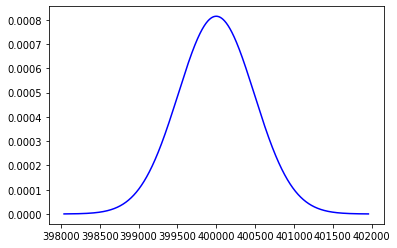

In [ ]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma)

# считаем вероятность хвоста справа от 399500 тыс.пользователей
result = distr.cdf(399500)
print('Вероятность того, что не более 399 500 пользователей откроют push-уведомление: ', result)

arange = np.arange((mu - 4 * sigma), (mu + 4 * sigma),1)
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.show()

#return result

ИТОГОВЫЙ ВЫВОД

<div class="alert alert-info">
    
В данном проекте было изучено 3 датафрейма:

1-й на 1565 строк с информацией о пользователях, в целом данные не нуждались в дополнительной предобработке. Во 2м датафрейме содержится 18068 строк с информацией о поездках данных пользователей за один год, данные о дате были переведены в формат даты, были обнаружены и удалены дубликаты (в количестве 31) . Третий датафрейм - "сервисный", в нем всего 2 строки с указанием условий подписки.

На этапе исследования данных мы объединили 3 датафрейма, для целей анализа добавили столбец с номером месяца, рассмотрели распределение пользователей по городам, их возрастное распределение и изучили дистанции поездок.

Самый часто встречающийся возраст - 25 лет, в основном пользователи попадают в категорию от 22 до 28 лет, а все возрастные категории лежат в промежутке от 12 до 43 лет.

Пользователи без подписки совершили 11568 поездок, средняя дистанция - 3045 м, медиана - 3148 м,  минимальная - 0,85м, максимальная - 7211 м. В промежуток между 1м и 3м квартилем попадает расстояние от 2366 до 3905 м. Пользователи с подпиской совершили 6500 поездок на среднюю дистанцию 3115 м., медиана - 3114 м, минимальная была на 244 м., максимальная на 5699 м., в промежуток между 1м и 3м квартилем попадает расстояние от  2785 до 3560 м. В среднем пользователь без подписки совершает 13,85 поездок, а пользователь с подпиской - 9,3 поездки.  
    
На гистограмме видно, что пользователи без подписки совершают большое количество коротких поездок, "всплеск" слева на короткие поездки у пользователей без подписки смещен к 500 м., а с подпиской - к 1000 м (что по всем поездкам в п.3.4. дает 700 м). В целом графики расстояний и длительности схожи, за исключением всплеска (около 100) коротких поездок без подписки. Тут возможны варианты: передумали, не разобрались, не понравилось.  
    
Таким образом, можно зафиксировать, что пользователи без подписки совершили почти вдвое больше поездок, средняя дистанция поездок без подписки незначительно меньше поездок по подписке, а вот разброс минимальных и максимальных значений без подписки гораздо шире, также шире диапазон 1-3й квартилей.

Были выдвинуты и проверены следующие гипотезы:
ГИПОТЕЗА №1, что среднее время поездок пользователей с подпиской ultra равно времени пользователей без подписки (альтернативная - среднее время поездок пользователей с подпиской ultra больше времени пользователей без подписки).
В ходе проверки мы отвергли нулевую гипотезу: среднее значение времени поездок пользователей с подпиской больше, чем пользователей без подписки.

ГИПОТЕЗА №2 Среднее расстояние, которое проезжают пользователи с подпиской равно 3130 метров (альтернативная - поезжают БОЛЬШЕ(?) 3130 метров).
В ходе проверки нулевую гипотезу не отвергаем, пользователи с подпиской проезжают меньше 3130 м. иными словами износ самокатов не выходит ли за пределы оптимальности, на платной подписке средняя длина поездки не превышает стандарт в 3130 м (а в исследовательской части мы выяснили, что средняя длина = 3115 м), т.о. и нулевая теория не отвергается, т.к. не выходит за пределы статистической значимости.

ГИПОТЕЗА №3 Выручка от пользователей c подпиской ultra равна выручке от пользователей без подписки (альтернативная - выручка от пользователей с подпиской ultra больше выручки от пользователей без подписки), в ходе проверки нулевая теория была отвергнута в пользу альтернативной, то есть пользователи с подпиской для сервиса аренды выгоднее.

КОНЕЧНО МОЖНО РЕЗЮМИРОВАТЬ, ЧТО ПОЛЬЗОВАТЕЛИ С ПОДПИСКОЙ ВЫГОДНЕЕ ДЛЯ СЕРВИСА АРЕНДЫ  Выручка от них больше, а самокаты они не "убивают". Прекрасные люди.